In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams.update({'figure.figsize':(10,6), 'image.cmap':'RdBu_r',
                     'font.size':14})

In [2]:
import datetime

In [3]:
import stravalib

In [4]:
with open('../api_key') as api_file:
    CLIENT_ID = api_file.readline().replace('\n','')
    CLIENT_SECRET = api_file.readline().strip()
    ACCESS_TOKEN = api_file.readline().strip()

In [5]:
# access using stored access token 
# can use id + secret to retrieve token as well using 
# client.exchange_code_for_token
client = stravalib.Client(access_token=ACCESS_TOKEN) 

print(client.get_athlete()) # me 

print(client.get_athlete(athlete_id=7656735))#stephanie

<Athlete id=1639875 firstname=b'Jake' lastname=b'Edman'>
<Athlete id=7656735 firstname=b'Stephanie' lastname=b'Wuerth'>


In [6]:
# get segment ids from most recent runs
segment_ids = []
for a in client.get_activities( limit = 5 ):
    # this is jank but I can't pass include_all_efforts to get_activities
    activity = client.get_activity(a.id, include_all_efforts = True) # return all segment efforts
    for effort in activity.segment_efforts:
        segment_ids.append(effort.segment.id)

In [7]:
print('number of segment efforts: {}'.format( len(segment_ids)))
segment_ids_unique = list(set(segment_ids))
print('number of unique segments: {}'.format( len(segment_ids_unique)))
# could choose to weight by frequency of segments, or not 

number of segment efforts: 135
number of unique segments: 95


In [8]:
# fixed stravalib so it takes context_entries now
# can return the whole leaderboard by requesting top_results_limit = 0, but that seems bad
#test = client.get_segment_leaderboard(segment_id = segment_ids[1], top_results_limit=1, context_entries=5)
# still can't get it to print less than 1 of the top entries though-- will have to strip that off 

In [9]:
## get a dictionary with segment_id as key, with all the nearby athletes in a dict 
segment_rivals = dict()
counter = 0
total = len(segment_ids_unique)
athlete_names = dict() # master table

for segment_id in segment_ids_unique:
    counter = counter + 1
    try:
        leaderboard = client.get_segment_leaderboard(segment_id = segment_id,
                                                     top_results_limit=1, context_entries=5)
        print('on segment {}, {} of {}'.format(segment_id, counter, total ))
    except:
        # janky error handling, should specify http error -- probably need urllib2
        print('whoops, error on {}, {} of {}'.format(segment_id, counter, total ))
    
    segment_athletes = dict()
    for i, entry in enumerate(leaderboard):
        # remove first entry 
        # should only do this if athlete isn't in top ranking
        if i == 0:
            continue
        else:
            segment_athletes[entry.athlete_id] = entry.athlete_name
            athlete_names[entry.athlete_id] = entry.athlete_name
    
    segment_rivals[segment_id] = segment_athletes
    
            
        
        
    

on segment 795650, 1 of 95
on segment 5372933, 2 of 95
on segment 1710600, 3 of 95
on segment 8525320, 4 of 95
on segment 2188818, 5 of 95
on segment 1086483, 6 of 95
on segment 4487188, 7 of 95
on segment 7233044, 8 of 95
on segment 9274904, 9 of 95
on segment 4892697, 10 of 95
on segment 8906264, 11 of 95
on segment 6996513, 12 of 95
on segment 7220787, 13 of 95
on segment 1565241, 14 of 95
on segment 1012803, 15 of 95
on segment 692805, 16 of 95
on segment 4383302, 17 of 95
on segment 11688028, 18 of 95
on segment 3663968, 19 of 95
on segment 6798952, 20 of 95
on segment 2599022, 21 of 95
on segment 3663982, 22 of 95
on segment 3238000, 23 of 95
on segment 813169, 24 of 95
on segment 8370292, 25 of 95
on segment 9598581, 26 of 95
on segment 1590393, 27 of 95
on segment 3783298, 28 of 95
on segment 2548356, 29 of 95
on segment 775819, 30 of 95
on segment 3147411, 31 of 95
on segment 3658388, 32 of 95
on segment 2615445, 33 of 95
on segment 5561499, 34 of 95
on segment 9174172, 35 of 

In [10]:
segment_rivals

{555711: {165916: 'Big Johnny Burton (runner)',
  1052005: 'Isaac Riffelmacher',
  1140612: 'catherine  kuhn',
  1639875: 'Jake Edman',
  1869067: 'Franz van der Groen',
  3232034: 'Eduardo Vazquez',
  4937373: 'David Grover',
  6718676: 'Steven Payne',
  7515773: 'David Crawford',
  7622450: 'Robert Benny',
  10261159: 'Adam Dell'},
 666295: {7296: 'Tyler Elliston',
  72811: 'Jukka Valkonen',
  190102: 'Tony Calvert',
  274548: 'Frank Riebli',
  476390: 'Jon Bretan',
  578140: 'jeff hutson',
  610045: 'David Kraybill',
  691989: 'Jameison Martin',
  1639875: 'Jake Edman',
  1727743: 'Topher Gaylord',
  14215439: 'Lucas Horan'},
 692805: {117763: 'Kevin Coady (TriForce!)',
  263323: 'David Weisz',
  978647: 'Billy Janhunen',
  1152767: 'Alexander Teran',
  1639875: 'Jake Edman',
  1788212: 'Darrin Banks',
  1940997: 'Fergal C',
  2527706: 'Kyle Ormsby',
  6451258: 'Brandon Brown',
  6727610: 'David Siegel',
  8439942: 'Reece Clark'},
 710891: {163986: 'Kim Christensen',
  263777: 'Mich

In [27]:
# make a frame with all of the rivals
df = pd.DataFrame.from_dict(segment_rivals, orient = 'index')
athlete_counts = df.count().to_frame('counts')
athlete_counts.index.name='athlete_id'

In [28]:
# make a frame with the names and ids
names = pd.Series(athlete_names).to_frame('athlete_name')
#names.rename(index = {0:'athlete_id'}, inplace=True)
names.index.name = 'athlete_id'

In [29]:
# join the frames
rival_counts = pd.merge(athlete_counts, names, how = 'inner', left_index = True, right_index = True)
rival_counts.index.name = 'athlete_id'

In [30]:
# here's the result! luckily i'm my own most common competitor
rival_counts.sort_values('counts', ascending=False)

,counts,athlete_name
athlete_id,,
1639875,95,Jake Edman
1055910,7,Nico Raffo
2028620,6,Aaron Steele
7325,6,Mike Sweeney
3706378,5,Leo Bialis-White
117763,5,Kevin Coady (TriForce!)
2601909,5,Torsten Heinemann
1095274,4,Mark Tanaka
1478007,4,Jim McCaffrey


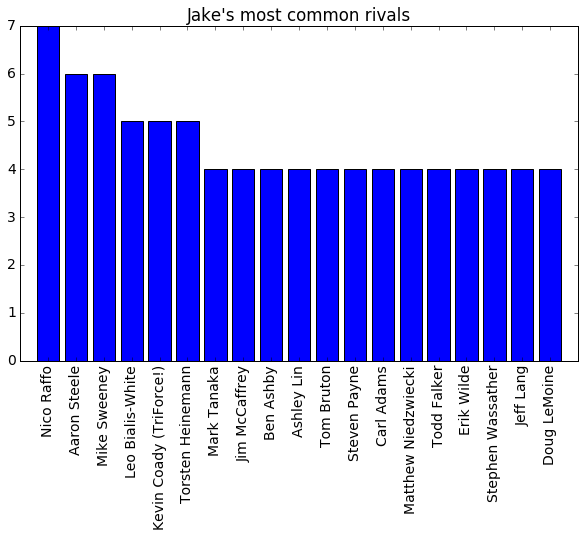

In [31]:
sorted_counts = rival_counts.sort_values('counts', ascending=False)
plt.bar( np.arange(1,20), sorted_counts.counts[1:20], align = 'center')
plt.xticks(np.arange(1,20), sorted_counts.athlete_name[1:20] , rotation = 90)
plt.title("Jake's most common rivals")

In [32]:
athlete_counts.to_csv('athlete_counts.csv')

In [33]:
names.to_csv('names.csv')

In [34]:
sorted_counts.to_csv('sorted_counts.csv')